In [1]:
%matplotlib inline

from __future__ import division
from os import listdir
from os.path import isfile, join
import numpy as np
import menpo.io as mio
from menpo.image import Image
from menpo.feature import greyscale, normalize_norm, normalize_std, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, progress_bar_str
from menpofit.visualize import visualize_fitting_results, plot_ced
from alaborticcv2015.alignment import LKFitter, FilteredSSD, FilteredFourierSSD

# Multipie experiment: Load Results

In [2]:
project_path = '/data/PhD/alaborticcv2015/'
results_path = 'results/multipie/'
path = project_path + results_path

file_names = [f for f in listdir(path) if isfile(join(path,f))]

In [10]:
results = []
errors = []
for j, file_name in enumerate(file_names):
    print_dynamic('{}{}'.format(file_name, progress_bar_str(j/len(file_names), show_bar=True)))
    
    # load results 
    rs = mio.import_pickle(path + file_name)
    # undo list nesting
    rs = [fr for fitting_results in rs for frs in fitting_results for fr in frs]
    results.append(r)
    # compute final errors
    e = [fr.final_error() for fr in rs]
    errors.append(e)
    
print_dynamic('{Done!')

multipie_pcadck_features_1_1_16_5_10.pkl.gz[====================] 100%

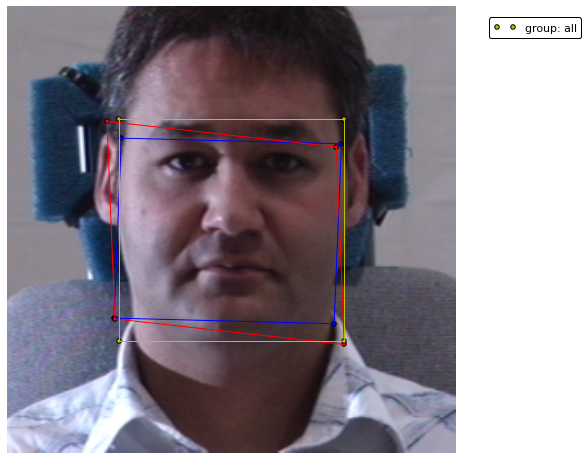

In [12]:
visualize_fitting_results(results[0])

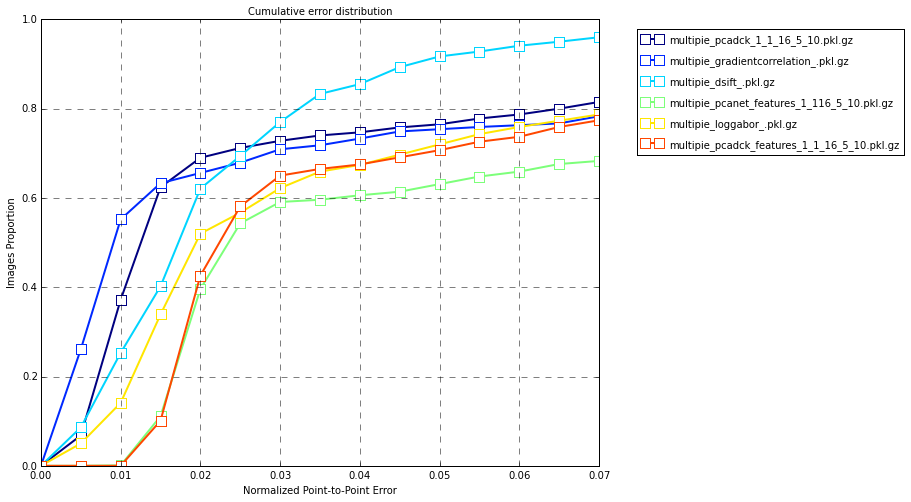

In [8]:
plot_ced(errors, legend_entries=file_names)

In [ ]:
file_name = (folder_path
                 + 'results/multipie/multipie_pcanet_1_1' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '_'
                 + str(noise_std)
                 + '.pkl.gz') 
    mio.export_pickle(fitter_results, file_name, overwrite=True)

In [ ]:
results = []
errors = np.empty((n_subjects, n_images_subject, n_rep, max_iters+len(scales)))

# for all subjects
for sub, subject in enumerate(subjects):
    
    template = subject['template']
    test_images = subject['test_images']
        
    string = '- network {}, {}, subject {}: '.format(nf, ps, sub)

    # load network
    file_name = (folder_path
                 + 'networks/pca_net/pca_net_1_1_' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '.pkl.gz') 
    net = mio.import_pickle(file_name)

    # define kernel function
    def kernel_func(ext_shape):
        return net._compute_kernel(ext_shape=ext_shape)

    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=features,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=FilteredFourierSSD,
                      kernel_func=kernel_func,
                      eps=-1)

    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[sub, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[sub, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[sub, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[sub, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[sub, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string + 
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))

    # save network fitting results
    file_name = (folder_path
                 + 'results/multipie/multipie_pcanet_1_1' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '_'
                 + str(noise_std)
                 + '.pkl.gz') 
    mio.export_pickle(fitter_results, file_name, overwrite=True)

    # save each image fitting result
    results.append(fitter_results)

In [ ]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)

# PCA Deep Convolutional Kernel features 

In [ ]:
results = []
errors = np.empty((n_subjects, n_images_subject, n_rep, max_iters+len(scales)))

# for all subjects
for sub, subject in enumerate(subjects):
    
    template = subject['template']
    test_images = subject['test_images']
        
    string = '- network {}, {}, subject {}: '.format(nf, ps, sub)

    # load network
    file_name = (folder_path
                 + 'networks/pca_net/pca_net_1_1_' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '.pkl.gz') 
    net = mio.import_pickle(file_name)

    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=net.kernel_response,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=FilteredSSD,
                      eps=-1)

    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[sub, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[sub, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[sub, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[sub, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[sub, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string + 
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))

    # save network fitting results
    file_name = (folder_path
                 + 'results/multipie/multipie_pcanet_1_1' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '_'
                 + str(noise_std)
                 + '.pkl.gz') 
    mio.export_pickle(fitter_results, file_name, overwrite=True)

    # save each image fitting result
    results.append(fitter_results)

In [ ]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)

# PCA Net features

In [ ]:
nf = 20
ps = 10

In [ ]:
results = []
errors = np.empty((n_subjects, n_images_subject, n_rep, max_iters+len(scales)))

# for all subjects
for sub, subject in enumerate(subjects):
    
    template = subject['template']
    test_images = subject['test_images']
        
    string = '- network {}, {}, subject {}: '.format(nf, ps, sub)

    # load network
    file_name = (folder_path
                 + 'networks/pca_net/pca_net_1_1_' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '.pkl.gz') 
    net = mio.import_pickle(file_name)

    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=net.network_response,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=FilteredSSD,
                      eps=-1)

    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[sub, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[sub, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[sub, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[sub, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[sub, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string + 
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))

#     # save network fitting results
#     file_name = (folder_path
#                  + 'results/multipie/multipie_pcanet_1_1' 
#                  + str(nf) 
#                  + '_' 
#                  + str(ps)
#                  + '_'
#                  + str(noise_std)
#                  + '.pkl.gz') 
#     mio.export_pickle(fitter_results, file_name, overwrite=True)

    # save each image fitting result
    results.append(fitter_results)

In [ ]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)